## Notebook to plot predictions of graph vs MLP

### plot examples predictions and distance on patients
### plot salient vertices and saliencies


In [1]:
import os
import sys
import numpy as np
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data


In [2]:
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [4]:
model_graph = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all'
model_pervertex= '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'

In [5]:
exp = meld_graph.experiment.Experiment.from_folder(model_graph)

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )

Initialised Experiment 23-10-30_LVHZ_dcp/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all


In [6]:
with h5py.File(os.path.join(model_graph, 'results_best_model', 'predictions.hdf5'), "r") as f:
    subjects_test = list(f.keys())
len(subjects_test)

453

In [7]:
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image

def load_predictions_for_subject(subj,model_dir,cohort,):
    #load mask
    s = MeldSubject(subj,cohort=cohort)
    hemi=s.get_lesion_hemisphere()
    dists, label = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                    )
    seg_pred = np.zeros(len(cohort.cortex_mask))
    dist_pred = np.zeros(len(cohort.cortex_mask))
    pred_file = os.path.join(model_dir, 'predictions.hdf5')
    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    seg_pred[cohort.cortex_mask] = result_hemis[hemi]
    distance_map = load_prediction(subj,pred_file, dset='distance_map')
    dist_pred[cohort.cortex_mask] = distance_map[hemi]
    file = os.path.join(model_pervertex, 'predictions_ensemble_iteration.hdf5')
    per_vertex = np.zeros(len(cohort.cortex_mask))
    per_vertex[cohort.cortex_mask] = load_prediction(subj,file, dset='prediction')[hemi]
    return label,seg_pred,dist_pred,per_vertex
    

In [94]:
# initialise subjects
subjects=[    
        # 'MELD_H21_15T_FCD_0050',
        # 'MELD_H4_3T_FCD_0016',
        'MELD_H10_3T_FCD_0014',
        ]

In [95]:
subjects = subjects_test
for subj in subjects[0:10]:
    print(subj)
    # get predictions and distance maps
    label,seg_pred,dist_pred,per_vertex = load_predictions_for_subject(subj, os.path.join(model_graph, 'results_best_model'),cohort)

    if ((seg_pred==label).any()) & ((per_vertex!=label).all()):
        print(subj)
    

MELD2_H7_3T_FCD_001
MELD2_H7_3T_FCD_004
MELD2_H7_3T_FCD_005
MELD2_H7_3T_FCD_009
MELD_H10_3T_C_0005


KeyError: None

In [91]:
subjects

['MELD2_H7_3T_FCD_001',
 'MELD2_H7_3T_FCD_004',
 'MELD2_H7_3T_FCD_005',
 'MELD2_H7_3T_FCD_009',
 'MELD_H10_3T_C_0005',
 'MELD_H10_3T_C_0006',
 'MELD_H10_3T_C_0009',
 'MELD_H10_3T_C_0011',
 'MELD_H10_3T_C_0012',
 'MELD_H10_3T_C_0013',
 'MELD_H10_3T_C_0014',
 'MELD_H10_3T_C_0015',
 'MELD_H10_3T_C_0017',
 'MELD_H10_3T_C_0018',
 'MELD_H10_3T_C_0019',
 'MELD_H10_3T_C_0021',
 'MELD_H10_3T_C_0022',
 'MELD_H10_3T_C_0025',
 'MELD_H10_3T_C_0028',
 'MELD_H10_3T_C_0029',
 'MELD_H10_3T_C_0031',
 'MELD_H10_3T_FCD_0002',
 'MELD_H10_3T_FCD_0009',
 'MELD_H10_3T_FCD_0013',
 'MELD_H10_3T_FCD_0014',
 'MELD_H10_3T_FCD_0016',
 'MELD_H11_3T_FCD_0002',
 'MELD_H11_3T_FCD_0006',
 'MELD_H11_3T_FCD_0007',
 'MELD_H11_3T_FCD_0009',
 'MELD_H11_3T_FCD_0010',
 'MELD_H11_3T_FCD_0011',
 'MELD_H11_3T_FCD_0015',
 'MELD_H11_3T_FCD_0019',
 'MELD_H11_3T_FCD_0020',
 'MELD_H11_3T_FCD_0025',
 'MELD_H11_3T_FCD_0027',
 'MELD_H11_3T_FCD_0028',
 'MELD_H11_3T_FCD_0030',
 'MELD_H11_3T_FCD_0031',
 'MELD_H11_3T_FCD_0040',
 'MELD_H11_3T

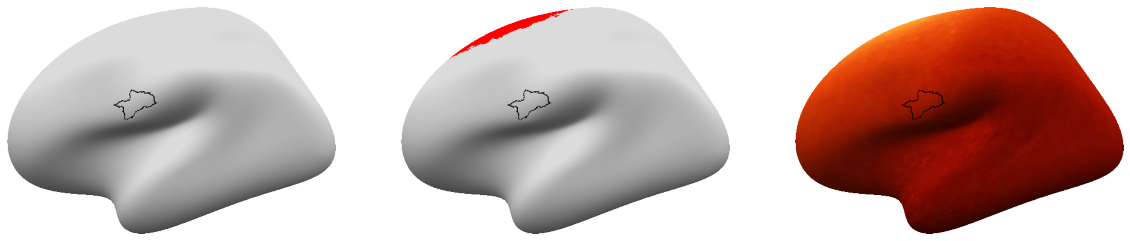

In [81]:
## plot prediction against MLP

for subj in subjects:
    # get predictions and distance maps
    label,seg_pred,dist_pred,per_vertex = load_predictions_for_subject(subj, os.path.join(model_graph, 'results_best_model'),cohort)

    #plot predictions using per-vertex graph
    per_vertex = per_vertex>0
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex,rotate=[90],
        cmap='bwr',
        base_size = 20,filename='tmp1.png', colorbar=False,mask=~per_vertex,
        parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_pv = trim(im)

    #plot predictions new graph and distance
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],seg_pred,
                  rotate=[90],cmap='bwr',
                    base_size = 20,filename='tmp1.png', colorbar=False,mask=~seg_pred.astype(bool),
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_graph = trim(im)
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],dist_pred,
                  rotate=[90],cmap='turbo',
                    base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_dist = trim(im)

    #combine plots
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(trimmed_pv)
    ax[1].imshow(trimmed_graph)
    ax[2].imshow(trimmed_dist)
    for ax in ax:
        ax.axis('off')

    #save plot
    # plt.savefig(f'{model_graph}/results_best_model/images/examples_patients_graphvsMLP_{subj}.png', transparent=True)



### plot salient vertices and saliencies 

In [2]:
from meld_graph.dataset import GraphDataset
from meld_graph.evaluation import Evaluator
import matplotlib as mpl
import matplotlib.cm as cm
from meld_graph.data_preprocessing import Preprocess
from meld_graph.confidence import get_confidence
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image


In [3]:
def get_subj_data(subject_id, eva):
    
    #load data for that subject
    data_dictionary = eva.load_data_from_file(subject_id, keys=['result','cluster_thresholded','input_features'], 
                                          split_hemis=True, )
    features_vals = data_dictionary['input_features']
    predictions = data_dictionary['cluster_thresholded']

    #find thresholds used if two thresholds
    if isinstance(eva.threshold, np.ndarray):
        if max(data_dictionary['result']['left'].max(), data_dictionary['result']['right'].max()) > eva.threshold[1]:
            threshold_text = "high confidence cluster"
        else :
            threshold_text = "No high confidence cluster\nLow confidence cluster given instead"
    else:
        threshold_text = ""
        
    #find clusters and load saliencies and confidence
    list_clust = {}
    confidences = {}
    saliencies = {}
    for hemi in ['left','right']:
        list_clust[hemi] = set(predictions[hemi])
        list_clust[hemi].remove(0.0)
        keys = [f'saliencies_{cl}' for cl in list_clust[hemi]] + [f'mask_salient_{cl}' for cl in list_clust[hemi]]
        saliencies.update(eva.load_data_from_file(subject_id, 
                                            keys=keys, 
                                            split_hemis=True))
    
        for cl in list_clust[hemi]:
            mask_salient = saliencies[f'mask_salient_{cl}'][hemi].astype(bool)
            confidence_cl_salient = data_dictionary['result'][hemi][mask_salient].mean()
            confidences[f'confidence_{cl}'] =  confidence_cl_salient

    return list_clust, features_vals, predictions, threshold_text, saliencies, confidences

def load_cmap():
    """ create the colors dictionarry for the clusters"""
    from matplotlib.colors import ListedColormap
    import numpy as np
    colors =  [
        [255,0,0],     #red
        [255,215,0],   #gold
        [0,0,255],     #blue
        [0,128,0],     #green
    ]
    colors=np.array(colors)/255
    dict_c = dict(zip(np.arange(1, len(colors)+1), colors))
    cmap = ListedColormap(colors)
    return cmap, dict_c

def create_surface_plots(surf,prediction,c, base_size=20):
    """plot and reload surface images"""
    cmap, colors =  load_cmap()
    tmp_file = 'tmp.png'
    msp.plot_surf(surf['coords'],
              surf['faces'],prediction,
              rotate=[90],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=1,vmax=len(colors) ,cmap=cmap,
              base_size=base_size,
              filename=tmp_file)
    im = Image.open(tmp_file)
    im = trim(im)
    im = im.convert("RGBA")
    im1 = np.array(im)
    msp.plot_surf(surf['coords'],
            surf['faces'],prediction,
              rotate=[270],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=1,vmax=len(colors),cmap=cmap,
              base_size=base_size,
              filename=tmp_file)
    im = Image.open(tmp_file)
    im = trim(im)
    im = im.convert("RGBA")
    im2 = np.array(im)
    plt.close('all')
    os.remove(tmp_file)
    return im1,im2


In [10]:
# load experiment
model_graph = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all'
exp = meld_graph.experiment.Experiment.from_folder(model_graph)
exp.data_parameters["augment_data"] = {}

#load trainval dataset
split = "test"

# subjects = exp.data_parameters["test_ids"]
subjects=[
        'MELD_H21_15T_FCD_0050', 
          'MELD_H4_3T_FCD_0016',
        #   'MELD_H10_3T_FCD_0014'

          ]

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode="test")
save_prediction_suffix=""

# create evaluator
eva = Evaluator(
    experiment=exp,
    checkpoint_path=model_graph,
    make_images=False,
    dataset=dataset,
    # save_dir=save_dir,
    cohort=cohort,
    subject_ids=subjects,
    mode="test",
    thresh_and_clust=True,
)


Initialised Experiment 23-10-30_LVHZ_dcp/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H21_15T_FCD_0050
Z-scoring data for MELD_H4_3T_FCD_0016
Evaluation test, min area threshold=100, threshold two_threshold(ymin=0.01, ymax=0.5)
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all/best_model.pt
Predicting model without dropout


using dataset


In [6]:
# calculate saliencies if does not exists
eva.calculate_saliency(save_prediction_suffix="")

calculating saliency
Loading and preprocessing test data
Z-scoring data for MELD_H10_3T_FCD_0014
calculating saliency for MELD_H10_3T_FCD_0014, cluster 1.0
/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 163842 equal to the number of examples.
  warnings.warn(
saving saliencies_1.0 for MELD_H10_3T_FCD_0014
saving mask_salient_1.0 for MELD_H10_3T_FCD_0014


In [11]:
 # setup parameters
base_feature_sets = [
    ".on_lh.gm_FLAIR_0.5.sm3.mgh",
    ".on_lh.wm_FLAIR_1.sm3.mgh",
    ".on_lh.curv.sm3.mgh",
    ".on_lh.pial.K_filtered.sm20.mgh",
    ".on_lh.sulc.sm3.mgh",
    ".on_lh.thickness_regression.sm3.mgh",
    ".on_lh.w-g.pct.sm3.mgh",
]

feature_names_sets = [
    "GM FLAIR (50%)",
    "WM FLAIR (1mm)",
    "Mean curvature",
    "Intrinsic Curvature",
    "Sulcal depth",
    "Cortical thickness",
    "Grey-white contrast",
]
NVERT=293804

for subject_id in subjects:
    subject = MeldSubject(subject_id, cohort=cohort)

    # initialise parameter for plot
    fig = plt.figure(figsize=(15, 8), constrained_layout=True)
    if subject.has_flair:
        base_features = base_feature_sets
        feature_names = feature_names_sets
    else:
        base_features = base_feature_sets[2:]
        feature_names = feature_names_sets[2:]
    # load predictions and data subject
    list_clust, features_vals, predictions, threshold_text, saliencies, confidences  = get_subj_data(subject_id, eva)
    # Loop over hemi
    for i, hemi in enumerate(["left", "right"]):
        # prepare grid plot
        gs1 = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.1, hspace=0.1)
        gs2 = GridSpec(2, 4, height_ratios=[1, 3], width_ratios=[1, 1, 0.5, 2], wspace=0.1)
        gs3 = GridSpec(1, 1)
        # plot predictions on inflated brain
        im1, im2 = create_surface_plots(cohort.surf, prediction=predictions[hemi], c=cohort)
        if hemi == "right":
            im1 = im1[:, ::-1]
            im2 = im2[:, ::-1]
        ax = fig.add_subplot(gs1[i, 1])
        ax.imshow(im1)
        ax.axis("off")
        title = 'Left hemisphere' if hemi=='left' else 'Right hemisphere'
        ax.set_title(title, loc="left", fontsize=20)
        ax = fig.add_subplot(gs1[i, 2])
        ax.imshow(im2)
        ax.axis("off")
        # initiate params for saliencies
        prefixes = [".combat", ".inter_z.intra_z.combat", ".inter_z.asym.intra_z.combat"]
        lims = 50   
        norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
        norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            "grpr",
            colors=[
                "#276419",
                "#FFFFFF",
                "#8E0152",
            ],
        )
        m = cm.ScalarMappable(norm=norm, cmap=cmap)
        labels = ["Harmonised", "Normalised", "Asymmetry"]
        hatching = ["\\\\", "//", "--"]
        # loop over clusters
        for cluster in list_clust[hemi]:
            fig2 = plt.figure(figsize=(17, 9))
            # get and plot saliencies
            saliencies_cl = saliencies[f'saliencies_{cluster}'][hemi]
            saliencies_cl = saliencies_cl * (NVERT/2)
                # plot prediction and salient vertices
            mask = np.array([predictions[hemi] == cluster])[0]
            mask_salient = saliencies[f'mask_salient_{cluster}'][hemi].astype(bool)
            mask_comb = mask.astype(int)+mask_salient.astype(int)                
            im1, im2 = create_surface_plots(cohort.surf, prediction=mask_comb, c=cohort, base_size=10)
            if hemi == "right":
                im1 = im1[:, ::-1]
                im2 = im2[:, ::-1]
            ax2 = fig2.add_subplot(gs2[1, 0])
            ax2.imshow(im1)
            ax2.axis("off")                
            ax2 = fig2.add_subplot(gs2[1, 1])
            ax2.imshow(im2)
            ax2.axis("off")
            # ax2.set_title('Predicted cluster and\n20% most salient vertices', loc="left", fontsize=15)
            ax2 = fig2.add_subplot(gs2[:, 3],)
            for pr, prefix in enumerate(prefixes):
                cur_data = np.zeros(len(base_features))
                cur_err = np.zeros(len(base_features))
                saliency_data = np.zeros(len(base_features))
                for b, bf in enumerate(base_features):
                    cur_data[b] = np.mean(
                        np.array(features_vals[hemi][mask_salient, features.index(prefix + bf)])
                    )
                    cur_err[b] = np.std(
                        np.array(features_vals[hemi][mask_salient, features.index(prefix + bf)])
                    )
                    saliency_data[b] = np.mean(
                        saliencies_cl[mask_salient ,features.index(prefix + bf)]
                        )
                ax2.barh(
                    y=np.array(range(len(base_features))) - pr * 0.3,
                    width=cur_data,
                    hatch=hatching[pr],
                    height=0.3,
                    edgecolor="k",
                    xerr=cur_err,
                    label=labels[pr],
                    color=m.to_rgba(saliency_data),
                )
            ax2.set_xlim([-8, 8])
            ax2.set_xticks([])
            ax2.set_yticks(np.array(range(len(base_features))) - 0.23)
            ax2.set_yticklabels(feature_names, fontsize=16)
            ax2.set_xlabel("Z score", fontsize=16)
            ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17), fontsize=16)
            fig2.colorbar(m, ax=ax2, ticks=[-50, -25, 0, 25, 50]).set_label(label='Saliency',size=18,weight='bold')
            ax2.set_autoscale_on(True)
            ## display info cluster
            # get size
            size_clust = np.sum(cohort.surf_area[predictions[hemi] == cluster]) / 100
            size_clust = round(size_clust, 3)
            # get confidence
            confidence = round(confidences[f'confidence_{cluster}'].mean(),2)
            # plot info in text box in upper left in axes coords
            textstr = "\n".join(
                (
                    f" Cluster {int(cluster)} on the {hemi} hemisphere",
                    " ",
                    f" Cluster size = {size_clust} cm2",
                    " ",
                    f" Confidence score =  {confidence}",
                    " ",
                    f"-{threshold_text}",
                    
                    
                )
            )
            props = dict(boxstyle="round", alpha=0.5)
            ax2 = fig2.add_subplot(gs2[0, 0:2])
            ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=18, verticalalignment="top", bbox=props)
            ax2.axis("off")
            fig2.savefig(f"{model_graph}/results_best_model/images/saliency_{subject.subject_id}_{hemi}_c{int(cluster)}.png", facecolor='white')

Loading and preprocessing test data
Z-scoring data for MELD_H21_15T_FCD_0050
Loading and preprocessing test data
Z-scoring data for MELD_H4_3T_FCD_0016
